In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [2]:
X = pd.read_excel('CTG(1).xlsx',usecols = "A:U")  # loading the input data
Y = pd.read_excel('CTG(1).xlsx',usecols = "V")  # loading the output data
input = X[1:].values
output = Y[1:].values

# Converting the output data using the one hot vector encoding
output_en = np_utils.to_categorical(output)

# Examples of conversion
print(output[:5])
print(output_en[:5, :])

[[9]
 [6]
 [6]
 [6]
 [2]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [3]:
# Split data into train and test
len_data = input.shape[0]
print(len_data)
train_size = int(len_data * .6)
valid_size = int(len_data * .1)
print ("Train size (60 %): ", train_size)
print ("Validation size (10 %): ", valid_size)
print ("Test size (30 %): ", (len_data - (train_size+valid_size)))

xtr = input[:train_size,:]
ytr = output_en[:train_size,:]
ytr_bool = output[:train_size]

xva = input[train_size:train_size+valid_size,:]
yva = output_en[train_size:train_size+valid_size,:]
yva_bool = output[train_size:train_size+valid_size]

xte = input[train_size+valid_size:,:]
yte = output_en[train_size+valid_size:,:]
yte_bool = output[train_size+valid_size:]

2126
Train size (60 %):  1275
Validation size (10 %):  212
Test size (30 %):  639


In [4]:
# Define model
model = Sequential()
model.add(Dense(25, input_shape = (21,), activation='relu'))
model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                286       
Total params: 1,486
Trainable params: 1,486
Non-trainable params: 0
_________________________________________________________________
None


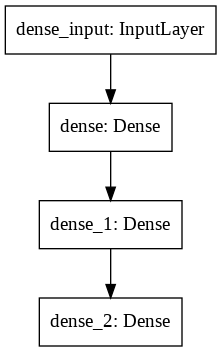

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [6]:
# Fit model
history = model.fit(tf.convert_to_tensor(xtr, dtype=tf.float32), \
                    ytr, validation_data=(tf.convert_to_tensor(xva, dtype=tf.float32), yva), epochs=30, batch_size=1, verbose=2)

Epoch 1/30
1275/1275 - 17s - loss: 1.7771 - accuracy: 0.3435 - val_loss: 1.6757 - val_accuracy: 0.2642
Epoch 2/30
1275/1275 - 2s - loss: 1.3685 - accuracy: 0.5004 - val_loss: 1.4473 - val_accuracy: 0.3491
Epoch 3/30
1275/1275 - 2s - loss: 1.2445 - accuracy: 0.5357 - val_loss: 1.3434 - val_accuracy: 0.4387
Epoch 4/30
1275/1275 - 2s - loss: 1.1647 - accuracy: 0.5592 - val_loss: 1.2827 - val_accuracy: 0.5566
Epoch 5/30
1275/1275 - 2s - loss: 1.0963 - accuracy: 0.5843 - val_loss: 1.2226 - val_accuracy: 0.5330
Epoch 6/30
1275/1275 - 2s - loss: 1.0519 - accuracy: 0.6110 - val_loss: 1.1180 - val_accuracy: 0.5849
Epoch 7/30
1275/1275 - 2s - loss: 1.0059 - accuracy: 0.6259 - val_loss: 1.0964 - val_accuracy: 0.5991
Epoch 8/30
1275/1275 - 2s - loss: 0.9698 - accuracy: 0.6314 - val_loss: 1.1102 - val_accuracy: 0.5802
Epoch 9/30
1275/1275 - 2s - loss: 0.9372 - accuracy: 0.6463 - val_loss: 1.1427 - val_accuracy: 0.5425
Epoch 10/30
1275/1275 - 2s - loss: 0.9009 - accuracy: 0.6635 - val_loss: 1.0588 -

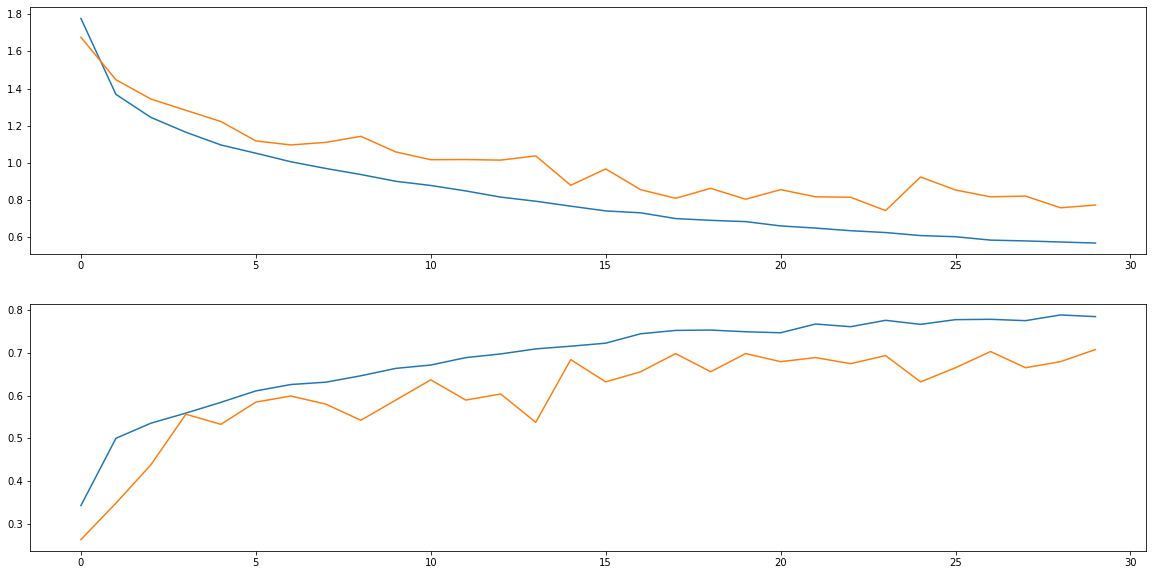

In [7]:
# Plot training and validation loss
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [8]:
# Evaluate and Predict
scores = model.evaluate(tf.convert_to_tensor(xtr, dtype=tf.float32), ytr, verbose=0)
print("Train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ytr_pred = model.predict_classes(tf.convert_to_tensor(xtr, dtype=tf.float32), verbose=0)
print("Train Accuracy by model.predict: %.2f%%" % (100*sum(ytr_bool.flatten() == ytr_pred)/ytr.shape[0]))

# make class predictions with the model
yva_pred = model.predict_classes(tf.convert_to_tensor(xva, dtype=tf.float32), verbose=0)
print("Val Accuracy by model.predict: %.2f%%" % (100*sum(yva_bool.flatten() == yva_pred)/yva.shape[0]))

# make class predictions with the model
yte_pred = model.predict(tf.convert_to_tensor(xte, dtype=tf.float32), batch_size=1, verbose=0)
yte_pred_bool = np.argmax(yte_pred, axis=1)
print("Test Accuracy by model.predict: %.2f%%" % (100*sum(yte_bool.flatten() == yte_pred_bool)/yte.shape[0]))

print("---------------TRAIN---------------------")
print(confusion_matrix(ytr_bool.flatten().tolist(), ytr_pred.tolist()))
print("---------------VAL---------------------")
print(confusion_matrix(yva_bool.flatten().tolist(), yva_pred.tolist()))
print("---------------TEST---------------------")
print(confusion_matrix(yte_bool.flatten().tolist(), yte_pred_bool.tolist()))


Train accuracy: 80.47%


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Train Accuracy by model.predict: 80.47%
Val Accuracy by model.predict: 70.75%
Test Accuracy by model.predict: 58.53%
---------------TRAIN---------------------
[[243  15   2   0   1   0   2   0   0   5]
 [ 37 296   0   1   3   8   0   0   0   1]
 [ 26   6   6   0   0   0   1   0   0   0]
 [  0   8   0  63   0   0   0   0   0   0]
 [ 17  15   0   0   6   0   0   0   0   6]
 [  6   8   0   0   0  98  13   0   0   0]
 [  3   0   1   0   0   6 103   0   0   0]
 [  0   0   0   0   0   0   2  11   0   0]
 [  1   0   0   0   0   0   0   0  55  13]
 [ 23   3   0   0   0   0   1   0  15 145]]
---------------VAL---------------------
[[16  1  1  0  0  0  0  0  0]
 [12 52  0  3  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [12  3  0  0  2  1  0  0  0]
 [ 0  6  0  0  0 47  8  0  0]
 [ 2  0  0  0  0  5 27  0  0]
 [ 0  0  0  0  0  0  1  3  0]
 [ 6  0  0  0  0  0  0  0  0]]
---------------TEST---------------------
[[ 33   7   0   0   0   0   5   0  17  36]
 [ 12 134   0  